# EducateR

very very very cooool

Notebook To View: http://nbviewer.jupyter.org/github/arose13/BiolStatsCourse/blob/master/EducateR.ipynb

**Question**
- What does an education actually get you

**Rubric**
- Can I understand what was done?
- Can I repeat what was done?
- Does the data viz effectively and thoroughly examine and show patterns/relations?
- Is the EDA a clear and appropriate examination the evidence and demonstrates statistical thinking?
- Is the final graphic and statistical test appropriate (tidy, polished, and meaningful) and suitable for publication?

In [1]:
%matplotlib inline
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as graph
from scipy.stats import shapiro, probplot, gamma
from IPython.display import display, Markdown
from statsmodels.formula.api import ols, glm


sns.set(font_scale=1.2, rc={'figure.figsize': (12, 5)})
graph.style.use('fivethirtyeight')
warnings.simplefilter('ignore')

In [2]:
# Pull the data in from github
data = pd.read_csv('https://raw.githubusercontent.com/cjlortie/education.value/gh-pages/data/education.income.csv')
print('Original Dataset Size', data.shape)

# afqt is a non-data column so I'm going to drop it. 
# Also since I have +7000 datapoints and only a few rows with NA I'm going to drop all of those 
data.drop('afqt', axis='columns', inplace=True)
data.dropna(axis='index', inplace=True)
print('Dataset Size after NA drops', data.shape)
display(data.head())

# Let's see some simple descriptive statistics
display(data.describe())

n_males, n_females = len(data[data['sex'] == 'male']), len(data[data['sex'] == 'female'])
print('N Males =', n_males)
print('N Females =', n_females)

Original Dataset Size (7006, 8)
Dataset Size after NA drops (6901, 7)


,income,height,weight,age,marital,sex,education
0,19000,60,155.0,53,married,female,13.0
1,35000,70,156.0,51,married,female,10.0
2,105000,65,195.0,52,married,male,16.0
3,40000,63,197.0,54,married,female,14.0
4,75000,66,190.0,49,married,male,14.0


,income,height,weight,age,education
count,6901.000000,6901.000000,6901.000000,6901.000000,6901.000000
mean,41395.474714,67.138531,188.297783,51.321548,13.211274
std,56176.348480,4.085101,44.478239,2.234430,2.603954
min,0.000000,52.000000,76.000000,47.000000,1.000000
25%,300.000000,64.000000,157.000000,49.000000,12.000000
50%,30000.000000,67.000000,184.000000,51.000000,12.000000
75%,55000.000000,70.000000,212.000000,53.000000,15.000000
max,343830.000000,84.000000,524.000000,56.000000,20.000000


N Males = 3386
N Females = 3515


Wow! There is a person in the dataset that weights 524lbs!? There is one particular red flag I have already spotted in the data. The age range is between 47-56. I expected age to be by far the most significant explanatory variable since age would have been a proxy for experience. I doubt this proxy will work with an age range this small but let's see anyway.  

# EDA 

Let's see what other surprises the data has instore for us!

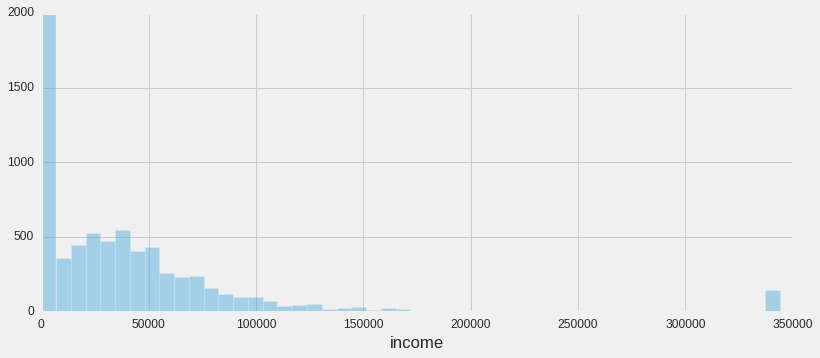

Education Possibilites [  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.]


In [3]:
# Distribution of Income
sns.distplot(data['income'], kde=False)
graph.show()

# All unique Education years
print('Education Possibilites', np.sort(data['education'].unique()))

Since every year of education is enumerated so treating it as a categorical won't help us out. I'll leave it as a continuous variable. 

There are also alot of people that are not working (why else are there incomes zero) and a few with stratospheric incomes. Those may have to be removed since they will almost certainly throw off the normality tests.

<center><h3>By Sex</h3></center>

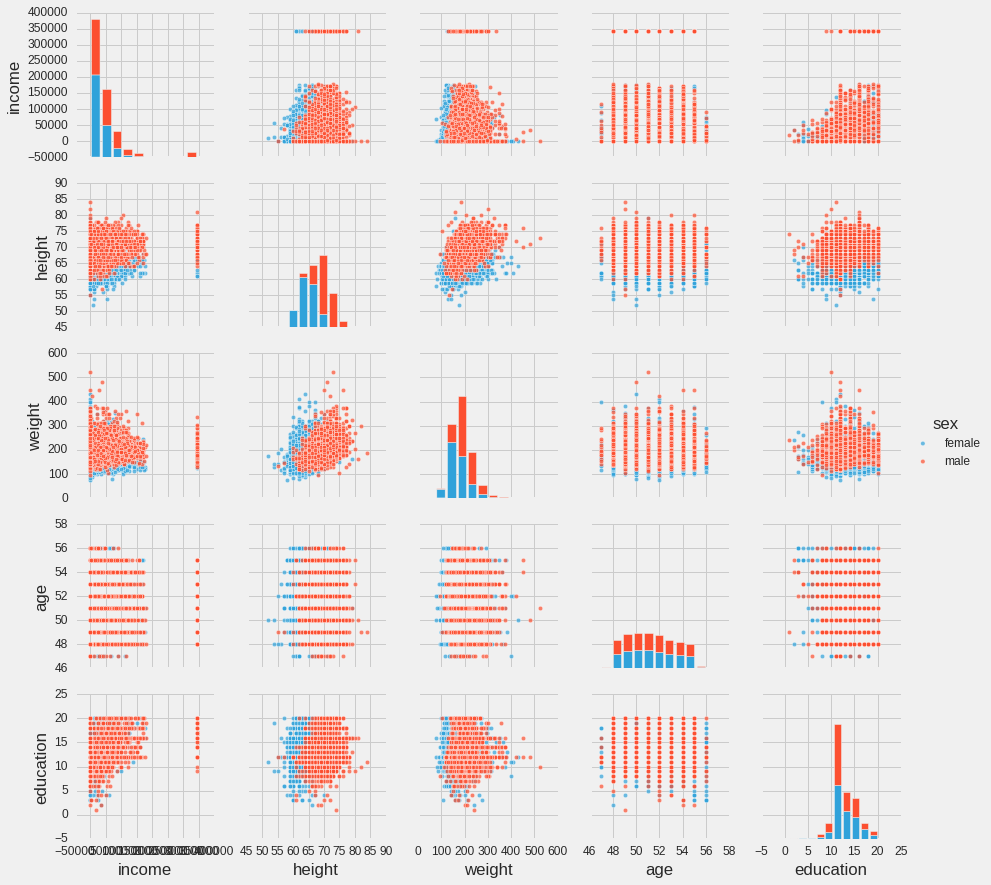

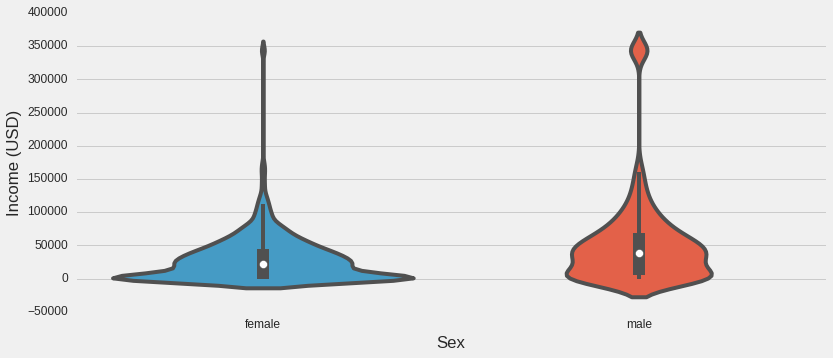

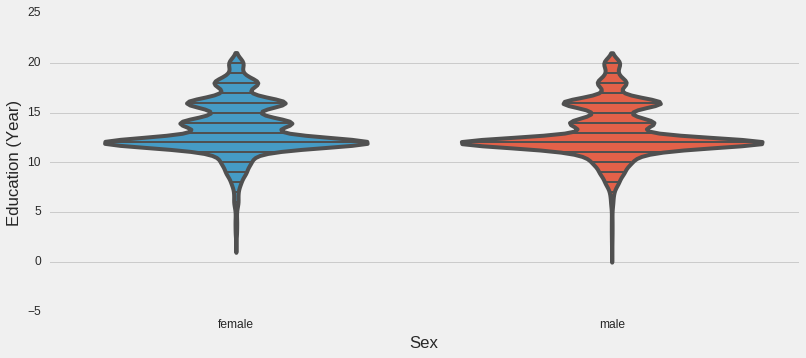

<center><h3>By Martial Status</h3></center>

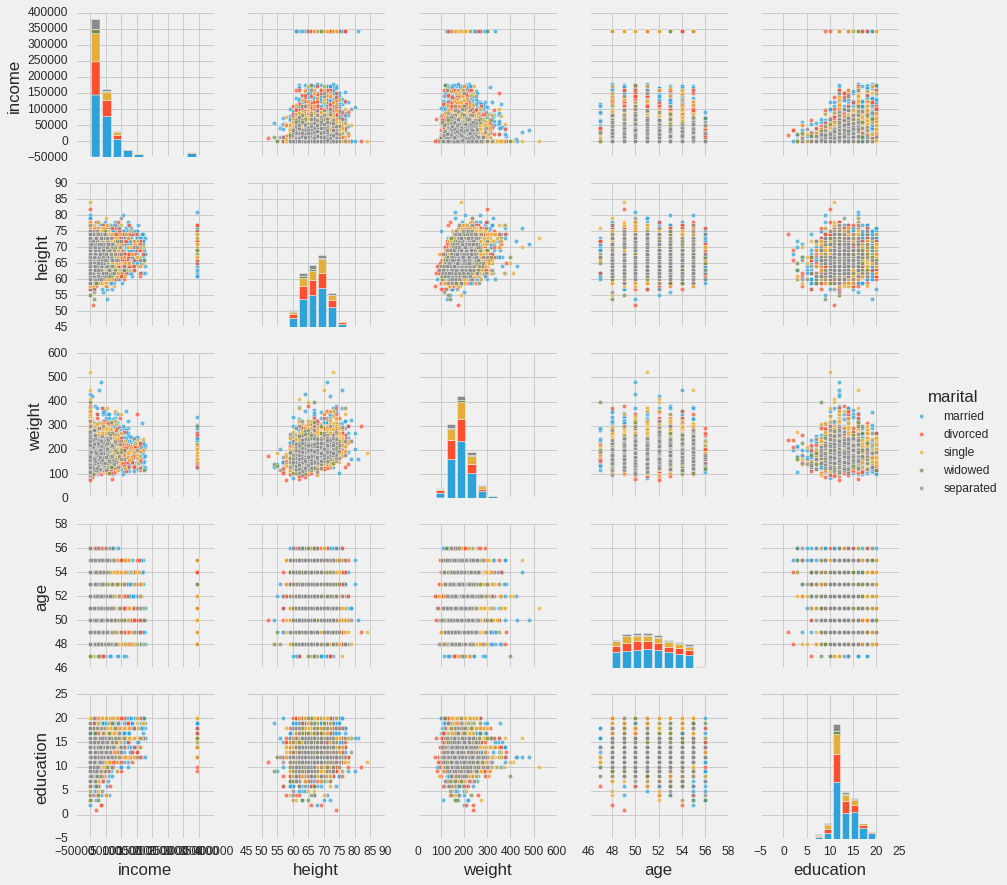

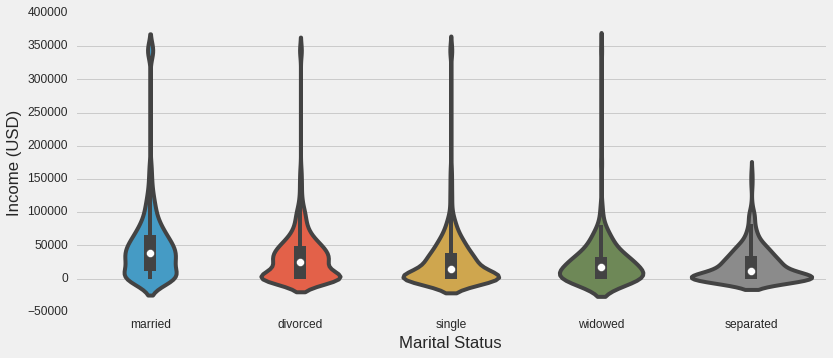

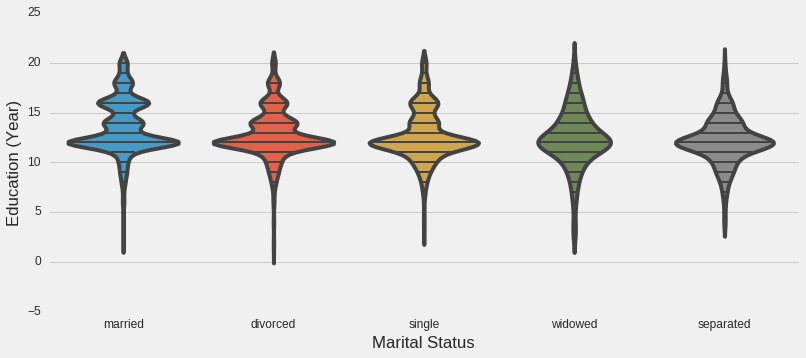

In [4]:
# I'm using violin plots with box plots inside them because the KDE of the voilin plots will better show where
# the data actually is.
# I'm also using pairplots, my favorite first step in EDA, because I really believe in the beginning you should 
# look at all your data points before you start. Things like boxplots and violin plots don't easily red flag if 
# 1 or a few points are going to influence the outcome of your model training and OLS cost functions are can be
# sensitive to outliers without algorithmic tricks like random sample consensus.

display(Markdown('<center><h3>By Sex</h3></center>'))
sns.pairplot(data, hue='sex', plot_kws={'alpha': 0.7})
graph.show()

sns.violinplot(x=data['sex'], y=data['income'])
graph.ylabel('Income (USD)')
graph.xlabel('Sex')
graph.show()

sns.violinplot(x=data['sex'], y=data['education'], inner='stick')
graph.ylabel('Education (Year)')
graph.xlabel('Sex')
graph.show()

display(Markdown('<center><h3>By Martial Status</h3></center>'))
sns.pairplot(data, hue='marital', plot_kws={'alpha': 0.7})
graph.show()

sns.violinplot(x=data['marital'], y=data['income'])
graph.ylabel('Income (USD)')
graph.xlabel('Marital Status')
graph.show()

sns.violinplot(x=data['marital'], y=data['education'], inner='stick')
graph.ylabel('Education (Year)')
graph.xlabel('Marital Status')
graph.show()

As expected age appears flat. Other studies (and common sense) have shown that old people make more than younger people so with this age range as small as it is it will probably not be a significant variable in our model.

I'll only do normality testing for the variables between the sexes as it appears to give the strongest group segregation. That being said, I am _very_ sure none of these groups are normally distributed.

The distribution of education is soo strange. Let's just see what happens.

In [5]:
# I am only going to show the qq plots for the non normal distributions
def run_normality_tests(df, col, where, by, alpha=0.01):
    subset = df[df[col] == where][by].values
    
    # Sharpiro Wilk Normality Test by Month
    _, p = shapiro(subset)
    
    # QQ-Plot
    if p > alpha:
        print('{} = {} do not reject'.format(col, where))
    else:
        print('REJECT! {} = {} p:{} Data is not Normal'.format(col, where, p))
        graph.figure(figsize=(4, 4))
        probplot(subset, plot=graph)
        graph.title('{} {}'.format(col, where))
        graph.show()

REJECT! sex = female p:0.0 Data is not Normal


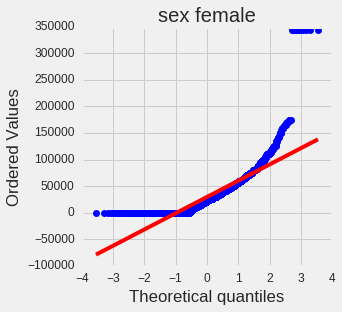

REJECT! sex = male p:0.0 Data is not Normal


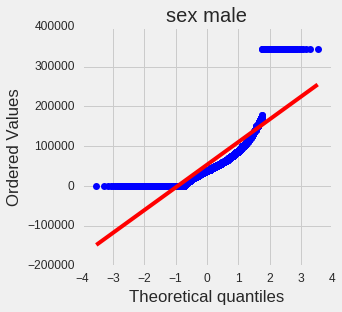

REJECT! marital = married p:0.0 Data is not Normal


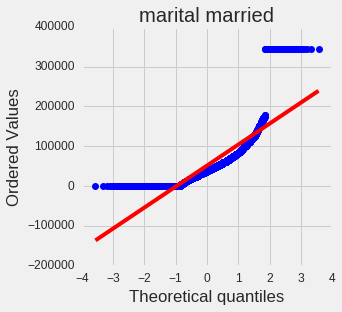

REJECT! marital = divorced p:0.0 Data is not Normal


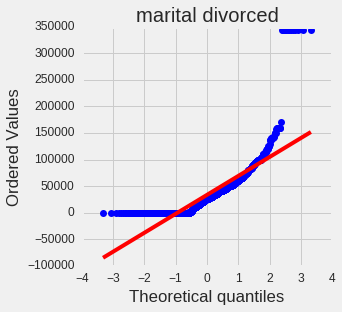

REJECT! marital = single p:5.605193857299268e-45 Data is not Normal


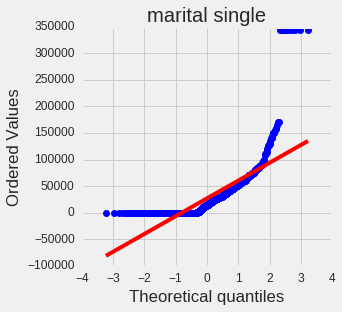

REJECT! marital = widowed p:6.053023379327491e-19 Data is not Normal


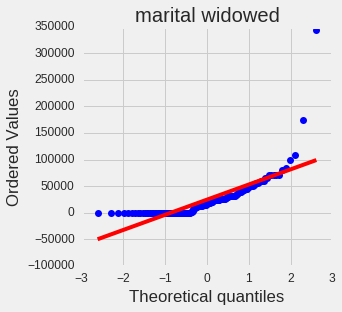

REJECT! marital = separated p:2.1403853707886867e-21 Data is not Normal


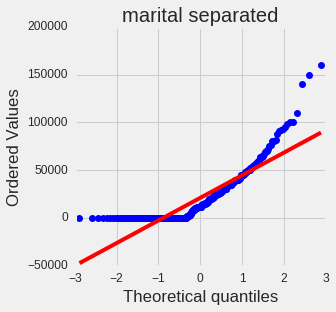

In [6]:
# I'm going to use an alpha of 0.01 because of how many normality tests I am about to run.
for sex in data['sex'].unique():
    run_normality_tests(data, 'sex', sex, 'income')

for status in data['marital'].unique():
    run_normality_tests(data, 'marital', status, 'income')

We have very non-normal data but this looks to be the case because of the zeros and the super extreme incomes. In my mind there are 2 things I can do...

1. I can run a RANSAC regression to deal with the outliers or
2. I can remove all the 0 and top 1% of income values then rerun the normality tests and do a normal GLM and ANOVA

In [7]:
# Top 1% of incomes are
income_1_percent = np.percentile(data['income'].values, 99)
print('Top 1% of incomes are', income_1_percent)

Top 1% of incomes are 343830.0


All 6901
No zero 5195
No zero no 1% 5052
--- Data Removed ---
Proportion of 0 USD Incomes removed were 0.218 Males, 0.276 Females
Proportion of Top 1% USD Incomes remvoed were 0.039 Males, 0.003 Females


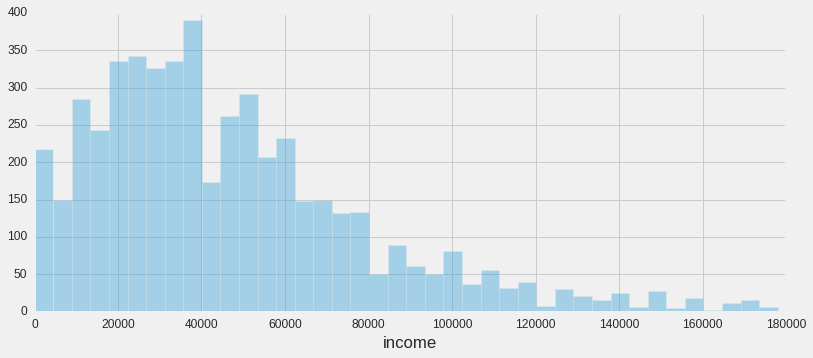

In [8]:
# Removing all 0 and top 1% of income datapoints.
print('All', len(data))

inlier_data = data[data['income'] > 0]
print('No zero', len(inlier_data))

inlier_data = inlier_data[inlier_data['income'] < income_1_percent]
print('No zero no 1%', len(inlier_data))

# REVISION
# Description of who were removed
print('--- Data Removed ---')
print('Proportion of 0 USD Incomes removed were {} Males, {} Females'.format(
        round(len(data[(data['income'] == 0) & (data['sex'] == 'male')]) / n_males, 3), 
        round(len(data[(data['income'] == 0) & (data['sex'] == 'female')]) / n_females, 3)
    ))

print('Proportion of Top 1% USD Incomes remvoed were {} Males, {} Females'.format(
        round(len(data[(data['income'] >= income_1_percent) & (data['sex'] == 'male')]) / n_males, 3),
        round(len(data[(data['income'] >= income_1_percent) & (data['sex'] == 'female')]) / n_females, 3)
    ))

sns.distplot(inlier_data['income'], kde=False)
graph.show()

**Beautiful!!!** Now this looks like a lognormal distribution. Our dataset started with ~7000 datapoints and now we have ~5000, we lost alot but we also since have a fantastic amount so I would not worry. 

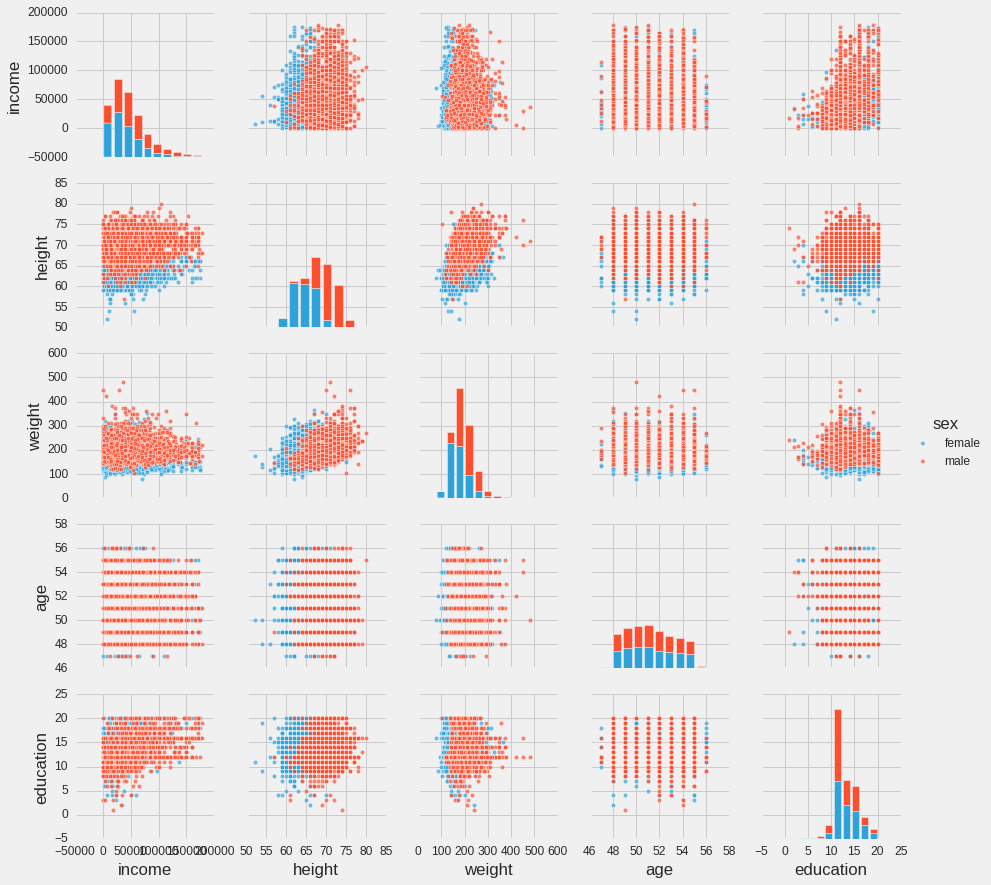

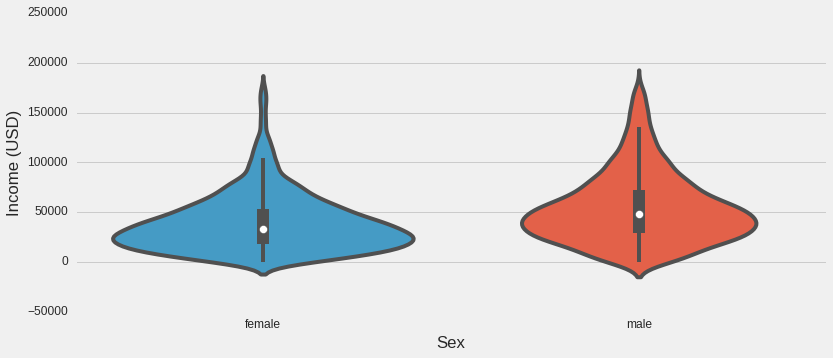

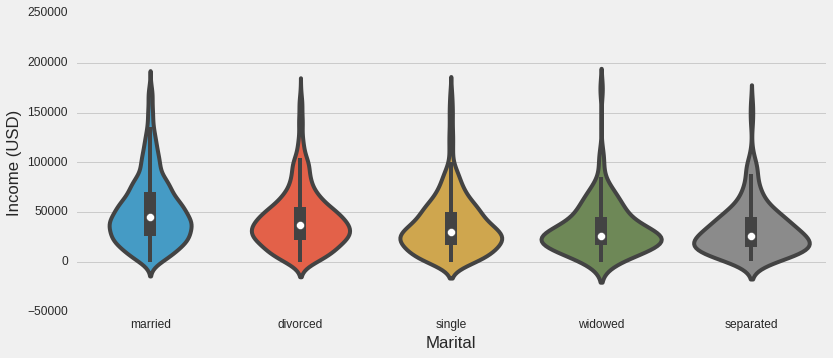

REJECT! sex = female p:1.7863361860941221e-38 Data is not Normal


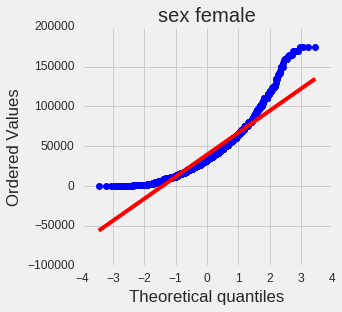

REJECT! sex = male p:9.900970275026875e-32 Data is not Normal


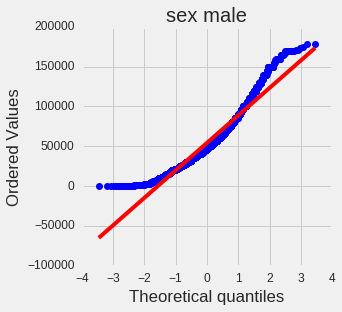

REJECT! marital = married p:1.6601373842179663e-35 Data is not Normal


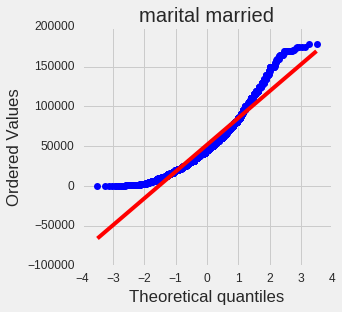

REJECT! marital = divorced p:1.0799626093763698e-24 Data is not Normal


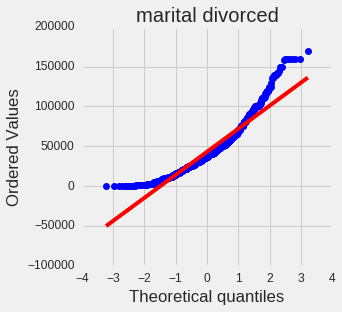

REJECT! marital = single p:1.4155590189259784e-22 Data is not Normal


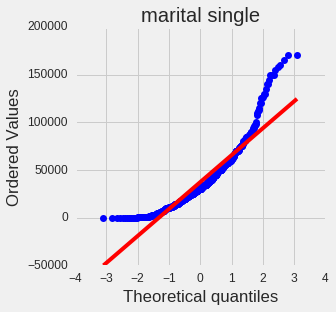

REJECT! marital = widowed p:4.282293186719244e-09 Data is not Normal


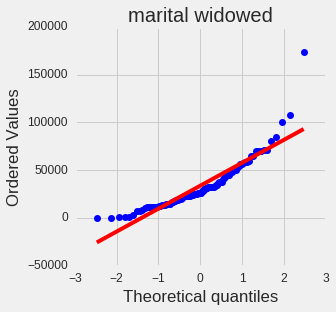

REJECT! marital = separated p:1.798542055304192e-13 Data is not Normal


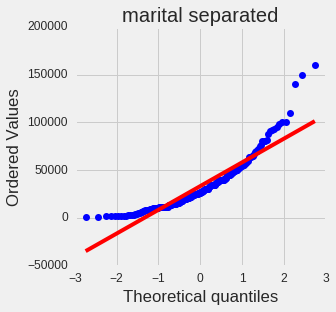

In [9]:
# Rerunning normality testing and visualisations!
sns.pairplot(inlier_data, hue='sex', plot_kws={'alpha': 0.7})
graph.show()

sns.violinplot(x=inlier_data['sex'], y=inlier_data['income'])
graph.ylabel('Income (USD)')
graph.xlabel('Sex')
graph.show()

sns.violinplot(x=inlier_data['marital'], y=inlier_data['income'])
graph.ylabel('Income (USD)')
graph.xlabel('Marital')
graph.show()

for sex in inlier_data['sex'].unique():
    run_normality_tests(inlier_data, 'sex', sex, 'income')

for status in inlier_data['marital'].unique():
    run_normality_tests(inlier_data, 'marital', status, 'income')

**That looks alot better.** I'll use this inlier dataset so you know I know how to do the things we learnt in class. We also cut down much of the 'gender gap' that was orginally there just by watching the naive differences in the means.

# Model Making 

Even after everything the data looks like a (cool) blob so I have a few mental red flags of what not to expect.

- I don't expect a high R<sup>2</sup> score.
- I don't expect there to be many sigificant explanatory variables.
- I expect education to be the most sigificant predictor (even if it's weak).

Also...
- I expect weight to interact with height but this interaction term shouldn't be significant or strongly significant.

$\alpha = 0.01$

In [10]:
print(data.columns)  # Just a reminder of all of our variables

Index(['income', 'height', 'weight', 'age', 'marital', 'sex', 'education'], dtype='object')


In [11]:
# Trial Models 
# (I know how haven't done thresholdouting to make sure I'm not doing any 'p-hacking' 
#  but I just don't have the time I think.)

# I'm using dataframe.sample to get random subsets of the data
model = ols(
    'income ~ education + C(marital) + C(sex) + age + weight + height', 
    data=inlier_data.sample(frac=0.7)
).fit()

display(sm.stats.anova_lm(model))
print(model.summary())

,df,sum_sq,mean_sq,F,PR(>F)
C(marital),4.0,1.300195e+11,3.250487e+10,38.301413,2.022756e-31
C(sex),1.0,1.656740e+11,1.656740e+11,195.218406,3.213112e-43
education,1.0,6.331592e+11,6.331592e+11,746.069519,3.548003e-149
age,1.0,1.066686e+07,1.066686e+07,0.012569,9.107411e-01
weight,1.0,2.841732e+08,2.841732e+08,0.334849,5.628544e-01
height,1.0,1.119373e+10,1.119373e+10,13.189891,2.854680e-04
Residual,3526.0,2.992375e+12,8.486598e+08,NaN,NaN


                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     123.1
Date:                Wed, 19 Oct 2016   Prob (F-statistic):          7.93e-202
Time:                        11:24:38   Log-Likelihood:                -41361.
No. Observations:                3536   AIC:                         8.274e+04
Df Residuals:                    3526   BIC:                         8.280e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
Intercept               -7

In [12]:
# I kicked out all the non significant variables and age was (as expected) on of them.
# I'm not surprised that height doesn't matter since studies have shown it only matters for males and half the
# sample are females.

model = ols(
    'income ~ education + C(sex) + C(marital)', 
    data=inlier_data.sample(frac=0.7)
).fit()

display(sm.stats.anova_lm(model))
print(model.summary())

,df,sum_sq,mean_sq,F,PR(>F)
C(sex),1.0,1.967722e+11,1.967722e+11,226.513453,1.156933e-49
C(marital),4.0,1.106601e+11,2.766501e+10,31.846460,4.185656e-26
education,1.0,6.295649e+11,6.295649e+11,724.720891,2.400234e-145
Residual,3529.0,3.065642e+12,8.686998e+08,NaN,NaN


                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     179.8
Date:                Wed, 19 Oct 2016   Prob (F-statistic):          3.63e-200
Time:                        11:24:38   Log-Likelihood:                -41404.
No. Observations:                3536   AIC:                         8.282e+04
Df Residuals:                    3529   BIC:                         8.286e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
Intercept               -3

# Final Model

In [13]:
# Final Model is fitted on all of the data since we aren't in the business of predicting this time around.
final_model = ols('income ~ education + C(sex) + C(marital)', data=inlier_data).fit()

display(sm.stats.anova_lm(final_model))
print(final_model.summary())

,df,sum_sq,mean_sq,F,PR(>F)
C(sex),1.0,2.793906e+11,2.793906e+11,328.551547,3.458422e-71
C(marital),4.0,1.776439e+11,4.441098e+10,52.225444,3.607331e-43
education,1.0,8.763270e+11,8.763270e+11,1030.523617,6.497051e-206
Residual,5045.0,4.290120e+12,8.503706e+08,NaN,NaN


                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     261.3
Date:                Wed, 19 Oct 2016   Prob (F-statistic):          5.89e-292
Time:                        11:24:38   Log-Likelihood:                -59103.
No. Observations:                5052   AIC:                         1.182e+05
Df Residuals:                    5045   BIC:                         1.183e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
Intercept               -3

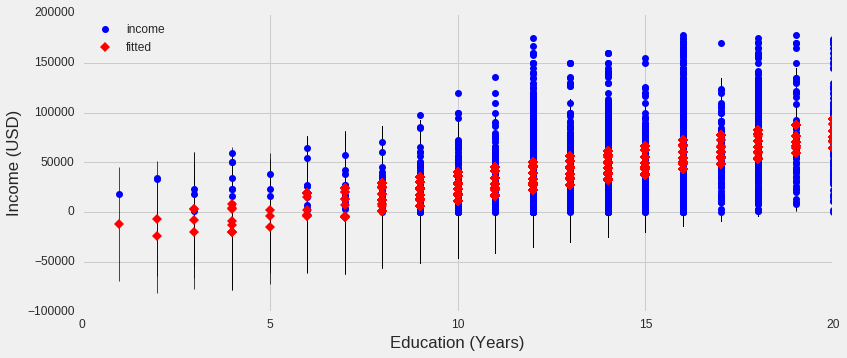

In [14]:
# REVISION
sm.graphics.plot_fit(final_model, 6)
graph.title('')
graph.ylabel('Income (USD)')
graph.xlabel('Education (Years)')
graph.show()

**Figure 1.1.** Fitted values shows the prediction if you control for what the model controls for and the 'income' are the actual observed income values. Vertical black lines represent 95% confidence intervals.

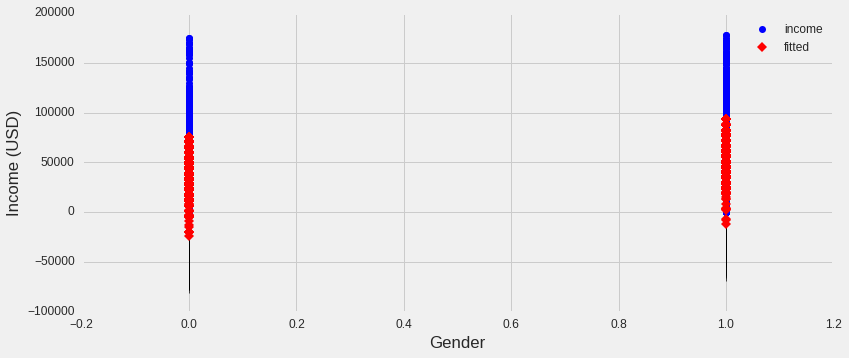

In [15]:
# REVISION
sm.graphics.plot_fit(final_model, 1)
graph.title('')
graph.ylabel('Income (USD)')
graph.xlabel('Gender')
graph.xlim([-0.2, 1.2])
graph.show()

**Figure 1.2.** Fitted values shows the prediction if you control for what the model controls for and the 'income' are the actual observed income values. Vertical black lines represent 95% confidence intervals. '0.0' is female and '1.0' is male.

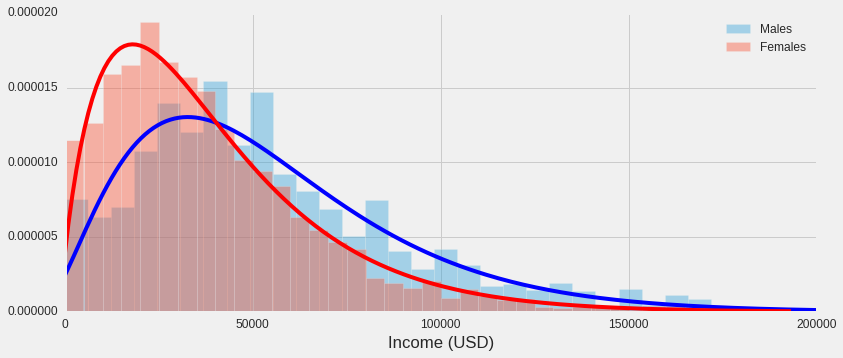

In [16]:
# REVISION
# Using the kind of plot to show better what the differences actually look like since it's hard to see.

sns.distplot(inlier_data[inlier_data['sex'] == 'male']['income'], fit=gamma,
             kde=False, label='Males', fit_kws={'color': 'b'})
sns.distplot(inlier_data[inlier_data['sex'] == 'female']['income'], fit=gamma,
             kde=False, label='Females', fit_kws={'color': 'r'})
graph.xlabel('Income (USD)')
graph.legend(loc=0)
graph.xlim([0, 200000])
graph.show()

**Figure 1.3.** Histogram showing the incomes of males and females with gamma distributions fitted to them. 

In [17]:
# REVISION
# ANNOTATION PARAGRAPH

# Conclusion

What is the value of a higher education? Alot. Education is the most significant covariate for income we had available and it is positive relationship. Undoubtedly choice in education matters alot more than just the number years of education on their own (First example a PhD in psychology gets paid less than a 2 year out of school salary of a petroleum engineer). There it is also about as strong of a relationship as I expected (The OLS model describes a ~5300 USD boost for every year of education you have given I know nothing else about you). 

I want to point out something that was brought up often when analysising this data by others that I feel, especially these days must be addressed. There is a small gender pay gap but that is to be expected since we were not able to control for the actually job choice difference that men and women as men usually chose jobs that pay more than those women tend to chose on average.

The largest, most robust and properly conducted study on the topic of the 'gender pay gap' was done by the US Department and Labor and CONSAD Research Corporation ended with this. 

>_This study leads to the unambiguous conclusion that the differences in the compensation of men and women are the result of a multitude of factors and that the raw wage gap should not be used as the basis to justify corrective action. Indeed, there may be nothing to correct. The differences in raw wages may be almost entirely the result of the individual choices being made by both male and female workers._
>
> **Charles E. James**, Deputy Assistant Secretary for Federal Contract Compliance